In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Support Vector Machine SVM**

kedi ve köpek arasindaki boundaryi kalin yapiyor yani labellari ayiriyor logistic regressiondaki 0.5`e karsi

dataya göre bir cutoff noktasi belirleyecek. LogReg de ise bunu 0.50de ortaya yerlestiriyor. Bu boundary lineer olmak zorunda degil

- calculate class probabilities
P(cat) in logit: if P(cat) > 0.5 then: Cat

in SVM ihtimal bu kadar basit degil

umursadigimiz sey modelin dogrulugu

**K Nearest Neighbors (KNN)**

KNN ve SVM works with distance EN yakin noktayi seciyorsun 3 mü 4 mü 6 mi ve en yakin noktalardan hangisi
daha fazla ise modelleme onu gösteriyor.

advantages: bütün datayi kullaniyor

disadvantage: quite slow it takes, computationally complex.

you need to standardize your data when the algorithm is distance based.EGer bunu yapmazsan compare etmek cok zor olcak ve sonuc cok farkli olacak. Standardize yapmazsan sonuc gene ortaya cikar ama sonuc kötü cikar.

hyperparameters: modellerin icindeki argumentlar onlari degistirebiliyorsun

## Reading and investigating the data

In [4]:
data = pd.read_csv('bankdata.csv')

In [5]:
data.shape

(74364, 9)

In [6]:
data.dtypes

type             object
operation        object
amount_total    float64
balance         float64
k_symbol         object
amount_left       int64
duration          int64
payments        float64
status           object
dtype: object

In [7]:
data.head()

,type,operation,amount_total,balance,k_symbol,amount_left,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


In [8]:
data['status'].value_counts()

A    64599
B     9765
Name: status, dtype: int64

### Investigating the numerical variables

In [9]:
data.describe()

,amount_total,balance,amount_left,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


#### Investigating variable duration

In [10]:
data['duration'].value_counts()

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

In [11]:
# we will convert this to a categorical
data['duration'] = data['duration'].apply(str)

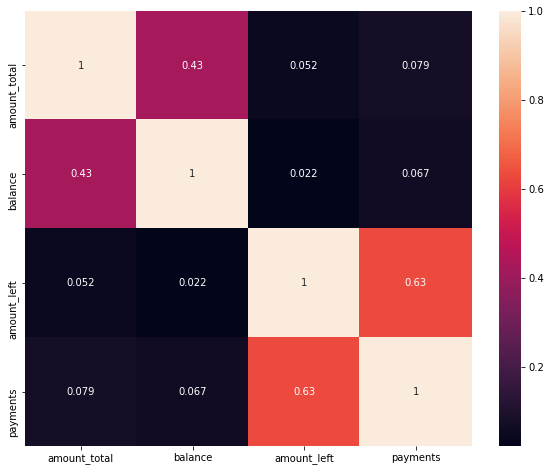

In [12]:
# Checking for multicollinearity
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data.corr(), annot=True)
plt.show()

payments and amount_left have a rather high correlation, so we will include only one of them in the model

C:\Users\cnr\.conda\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


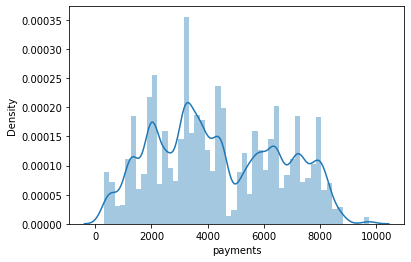

In [13]:
#sns.distplot(data['amount_total'])
#plt.show()

#sns.distplot(data['balance'])
#plt.show()

sns.distplot(data['payments'])
plt.show()

### Preprocessing the numerical variables

In [14]:
from sklearn.preprocessing import StandardScaler
data_num = data.select_dtypes(include = np.number).drop(columns = 'amount_left')
print(data_num.head())
# Standardizing data
transformer = StandardScaler().fit(data_num)
data_num_standardized = transformer.transform(data_num)
x = pd.DataFrame(data_num_standardized, columns = data_num.columns)
print(x.head())

   amount_total  balance  payments
0       44749.0  45549.0    3317.0
1        1000.0   1000.0    4399.0
2        1100.0   1100.0     609.0
3         700.0    700.0    1921.0
4         900.0    900.0    3492.0
   amount_total   balance  payments
0      3.147453 -0.018599 -0.471289
1     -0.582545 -1.769754  0.019231
2     -0.574019 -1.765823 -1.698947
3     -0.608123 -1.781547 -1.104158
4     -0.591071 -1.773685 -0.391953


C:\Users\cnr\.conda\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


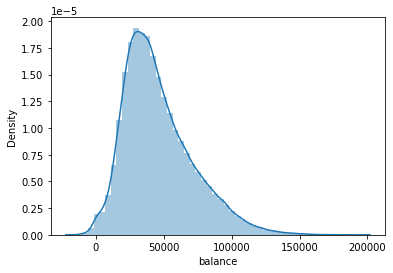

In [15]:
sns.distplot(data['balance'])
plt.show()

C:\Users\cnr\.conda\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


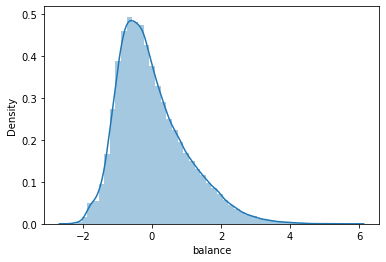

In [16]:
sns.distplot(x['balance'])
plt.show()

### Getting dummies for the categorical variables

In [17]:
from sklearn.preprocessing import OneHotEncoder
cat = data.select_dtypes(include = np.object).drop(columns = 'status')
enc = OneHotEncoder()
categorical = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())
categorical.head()

,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,x2_pojistne,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
categorical.sum(axis = 1)

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
74359    4.0
74360    4.0
74361    4.0
74362    4.0
74363    4.0
Length: 74364, dtype: float64

In [19]:
y = data['status']
X = pd.concat((x, categorical), axis=1)
X.head()

,amount_total,balance,payments,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,...,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,3.147453,-0.018599,-0.471289,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.582545,-1.769754,0.019231,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.574019,-1.765823,-1.698947,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.608123,-1.781547,-1.104158,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.591071,-1.773685,-0.391953,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Splitting into train and test set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter = 500).fit(X_train, y_train)

In [22]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.8806226047199623

In [23]:
y_test.value_counts()

A    25839
B     3907
Name: status, dtype: int64

In [24]:
pd.Series(predictions).value_counts()

A    29118
B      628
dtype: int64

What happened in terms of the classes?

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [26]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

0.9948228333221274

In [27]:
pd.Series(predictions).value_counts()

A    25815
B     3931
dtype: int64

In [28]:
decisiontree.feature_importances_

array([1.59567949e-02, 1.23331242e-01, 6.60032339e-01, 1.48304421e-03,
       5.84855729e-04, 2.32896616e-04, 1.81199037e-03, 6.12256370e-04,
       1.64264348e-03, 5.71355090e-04, 2.43999702e-04, 0.00000000e+00,
       5.19590488e-04, 0.00000000e+00, 3.40611300e-04, 2.36204605e-04,
       1.99313755e-04, 7.83427850e-02, 7.16328531e-02, 1.45125491e-02,
       9.69774718e-03, 1.80149280e-02])

In [29]:
print(dict(zip(X.columns, decisiontree.feature_importances_)))

{'amount_total': 0.015956794947824756, 'balance': 0.12333124212529539, 'payments': 0.6600323389220761, 'x0_PRIJEM': 0.0014830442073300474, 'x0_VYBER': 0.0005848557293973857, 'x0_VYDAJ': 0.0002328966156404733, 'x1_prevod': 0.001811990372950384, 'x1_unknown': 0.0006122563703656662, 'x1_vklad': 0.0016426434787289931, 'x1_vyber': 0.0005713550901558043, 'x2_pojistne': 0.00024399970221126164, 'x2_sankc. urok': 0.0, 'x2_sipo': 0.000519590488138483, 'x2_sluzby': 0.0, 'x2_unknown': 0.0003406113003741925, 'x2_urok': 0.00023620460464083223, 'x2_uver': 0.00019931375543874447, 'x3_12': 0.07834278496283245, 'x3_24': 0.0716328531038693, 'x3_36': 0.014512549070533069, 'x3_48': 0.009697747177566458, 'x3_60': 0.018014927974630023}


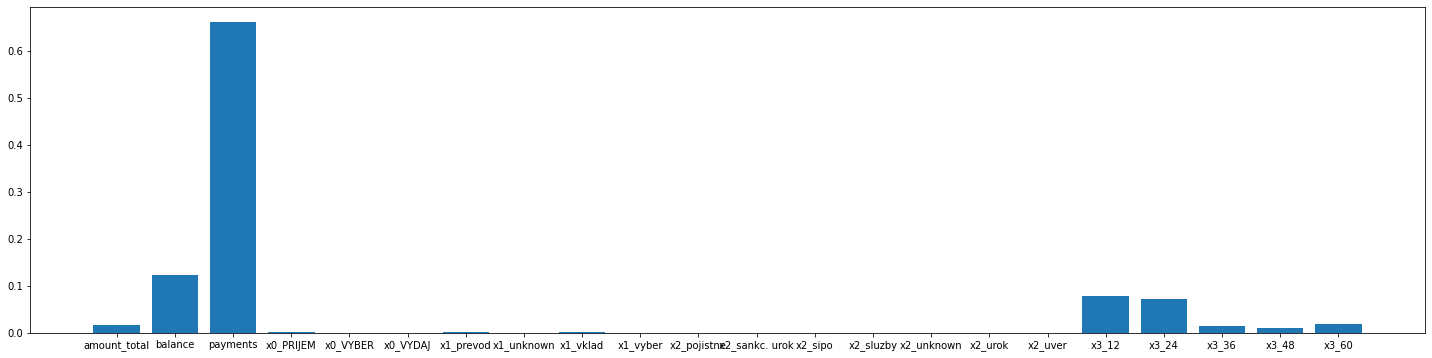

In [30]:
plt.rcParams['figure.figsize'] = [25, 6]
plt.bar(height = decisiontree.feature_importances_, x = X.columns)
plt.show()

## SVM

In [41]:
from sklearn.svm import SVC

svm = SVC().fit(X_train, y_train)
predictions = svm.predict(X_test)
print(svm.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

0.8984737443689907
A    28611
B     1135
dtype: int64


In [36]:
# we will calculate class probabilitites
# P(cat)
# in logit if P(cat) > 0.5 then:Cat
# here: it is not that straightforward

## K-Nearest Neighbors

In [43]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbors = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
predictions = nearest_neighbors.predict(X_test)
print(nearest_neighbors.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

0.9279567000605123
A    26390
B     3356
dtype: int64


In [35]:
# kendisine ne yakinsa onu seciyor
# yakin datapointlere bakip, yeni bir datapointin neye ait olacabilecegini gösteriyor
# good at all of the data that is available
# can be pretty slow, can result in underperformance if this data contains many features
# how many neighbors you wanna take into consideration k=3, k=6, default is 5

In [ ]:
#whenever algorithm is on distance base you need to normalize your data
# yani data biri 1000 digeri 1000000 ise k-nearest ve Svm icin normalize yapman önemli

In [ ]:
# score is classification
# rscore is for regression

# Supervised Learning: Regression

In [40]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# SVR
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor